<a href="https://colab.research.google.com/github/TheAlchemist010/DeepLearning-Notebooks/blob/main/FIT3181/A1_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="color:#0b486b">  FIT3181: Deep Learning (2024)</span>
***
*CE/Lecturer (Clayton):*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Lecturer (Clayton):* **Prof Dinh Phung** | dinh.phung@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Arghya Pal** | arghya.pal@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Lim Chern Hong** | lim.chernhong@monash.edu <br/>  <br/>
*Head Tutor 3181:*  **Miss Vy Vo** |  \[v.vo@monash.edu \] <br/>
*Head Tutor 5215:*  **Dr Van Nguyen** |  \[van.nguyen1@monash.edu \]

<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***

# <span style="color:#0b486b">  Student Information</span>
***
Surname: **Gallagher**  <br/>
Firstname: **Daniel**    <br/>
Student ID: **33094969**    <br/>
Email: **dgal0013@student.monash.edu**    <br/>
Your tutorial time: **Monday 4-6PM**    <br/>
***

# <span style="color:#0b486b">Deep Neural Networks</span>
### Due: <span style="color:red">11:55pm Sunday, 8 September 2024</span>  (Sunday)

#### <span style="color:red">Important note:</span> This is an **individual** assignment. It contributes **25%** to your final mark. Read the assignment instructions carefully.

## <span style="color:#0b486b">What to submit</span>

This assignment is to be completed individually and submitted to Moodle unit site. **By the due date, you are required to submit one  <span style="color:red; font-weight:bold">single zip file, named xxx_assignment01_solution.zip</span> where `xxx` is your student ID, to the corresponding Assignment (Dropbox) in Moodle**. You can use Google Colab to do Assigmnent 1 but you need to save it to an `*.ipynb` file to submit to the unit Moodle.

**More importantly, if you use Google Colab to do this assignment, you need to first make a copy of this notebook on your Google drive**.

***For example, if your student ID is <span style="color:red; font-weight:bold">12356</span>, then gather all of your assignment solution to folder, create a zip file named <span style="color:red; font-weight:bold">123456_assignment01_solution.zip</span> and submit this file.***

Within this zip folder, you **must** submit the following files:
1.	**Assignment01_solution.ipynb**:  this is your Python notebook solution source file.
1.	**Assignment01_output.html**: this is the output of your Python notebook solution *exported* in html format.
1.	Any **extra files or folder** needed to complete your assignment (e.g., images used in your answers).

Since the notebook is quite big to load and work together, one recommended option is to split solution into three parts and work on them seperately. In that case, replace **Assignment01_solution.ipynb** by three notebooks: **Assignment01_Part1_solution.ipynb**, **Assignment01_Part2_solution.ipynb** and **Assignment01_Part3_solution.ipynb**

**You can run your codes on Google Colab. In this case, you have to make a copy of your Google colab notebook including the traces and progresses of model training before submitting.**



## <span style="color:#0b486b">Part 3: Convolutional Neural Networks and Image Classification</span>

**<div style="text-align: right"><span style="color:red">[Total marks for this part: 45 points]</span></div>**

The third part of this assignment is to demonstrate your basis knowledge in deep learning that you have acquired from the lectures and tutorials materials. Most of the contents in this assignment are drawn from **the tutorials covered from weeks 3 to 6**. Going through these materials before attempting this assignment is highly recommended.

**The dataset used for this part is a specific dataset for this unit consisting of approximately $10,000$ images of $20$ classes of Animals, each of which has approximately 500 images. You can download the dataset at [download here](https://drive.google.com/file/d/1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG/view?usp=drive_link) if you want to do your assignment on your machine.**


In [ ]:
import os
import requests
import tarfile
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.nn as nn
import torch
import PIL.Image
import pathlib
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1234)

Download the dataset to the folder of this Google Colab.

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG/view?usp=drive_link

We unzip the dataset to the folder.

In [ ]:
!unzip -q Animals_Dataset.zip

In [ ]:
data_dir = "./FIT5215_Dataset"

# We resize the images to [3,64,64]
transform = transforms.Compose([transforms.Resize((64,64)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      #transforms.RandomRotation(4),     #Rotates the image to a specified angel
                                      #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # convert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images, each R,G,B value is normalized with mean=0.5 and std=0.5
                                      ])


# Load the dataset using torchvision.datasets.ImageFolder and apply transformations
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, valid_size])

# Example of DataLoader creation for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Number of instance in train_set: %s" % len(train_dataset))
print("Number of instance in val_set: %s" % len(val_dataset))

In [ ]:
class_names = ['bird', 'bottle', 'bread', 'butterfly', 'cake', 'cat', 'chicken', 'cow', 'dog', 'duck',
                  'elephant', 'fish', 'handgun', 'horse', 'lion', 'lipstick', 'seal', 'snake', 'spider', 'vase']

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

In [ ]:
import math

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def visualize_data(images, categories, images_per_row = 8):
    class_names = ['bird', 'bottle', 'bread', 'butterfly', 'cake', 'cat', 'chicken', 'cow', 'dog', 'duck',
                  'elephant', 'fish', 'handgun', 'horse', 'lion', 'lipstick', 'seal', 'snake', 'spider', 'vase']
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        imshow(images[i])
        class_index = categories[i]
        plt.xlabel(class_names[class_index])
    plt.show()

In [ ]:
visualize_data(images, labels)

**For questions 3.1 to 3.7, you'll need to write your own model in a way that makes it easy for you to experiment with different architectures and parameters. The goal is to be able to pass the parameters to initialize a new instance of `YourModel` to build different network architectures with different parameters. Below are descriptions of some parameters for `YourModel`:**

1. `Block confirguration`: Our network consists of many blocks. Each block has the pattern `[conv, batch norm, activation, conv, batch norm, activation, max pool, dropout]`. All convolutional layers have filter size $(3, 3)$, strides $(1, 1)$ and padding = 1, and all max pool layers have strides $(2, 2)$, kernel size $2$, and padding = 0. The network will consists of a few blocks before applying a linear layer to output the logits for the softmax layer.

2. `list_feature_maps`: the number of feature maps in the blocks of the network. For example, if `list_feature_maps = [16, 32, 64]`, our network has three blocks with the input_channels or number of feature maps are `16, 32`, and `64` respectively.
3. `drop_rate`: the keep probability for dropout. Setting `drop_rate` to $0.0$ means not using dropout.
4. `batch_norm`: the batch normalization function is used or not. Setting `batch_norm` to `false` means not using batch normalization.
5. `use_skip`: the skip connection is used in the blocks or not. Setting this to `true` means that we use `1x1` Conv2D with `strides=2` for the skip connection.
6. At the end, you need to apply `global average pooling (GAP)` (`AdaptiveAvgPool2d((1, 1))`) to flatten the 3D output tensor before defining the output linear layer for predicting the labels.



Here is the model confirguration of `YourCNN` if the `list_feature_maps = [16, 32, 64]` and `batch_norm = true`.

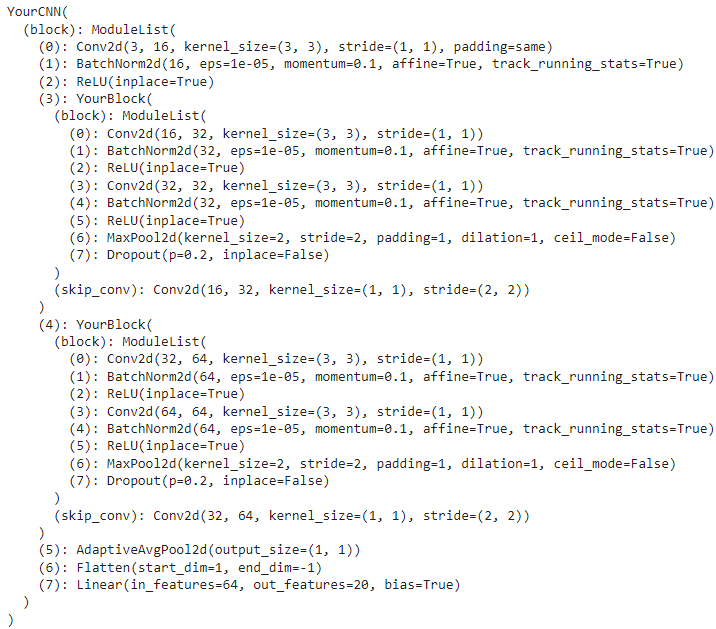

<span style="color:red">**Question 3.1:**</span> **You need to implement the aforementioned CNN**.

**First, you need to implement the block of our CNN in the class `YourBlock`. You can ignore `use_skip` and `skip connection` for simplicity. However, you cannot earn full marks for this question.**

<div style="text-align: right"> <span style="color:red">[6 points]</span> </div>

In [ ]:
#Your code here
class YourBlock(nn.Module):
  def __init__(self, in_feature_maps, out_feature_maps, drop_rate = 0.2, batch_norm = True, use_skip = True):
    super(YourBlock, self).__init__()
    self.use_skip = use_skip
    #Your code here





  def forward(self, x):
    #Write your code here






**Second, you need to use the above `YourBlock` to implement the class `YourCNN`**.

<div style="text-align: right"> <span style="color:red">[6 points]</span> </div>

In [ ]:
class YourCNN(nn.Module):
  def __init__(self, list_feature_maps = [16, 32, 64], drop_rate = 0.2, batch_norm= True, use_skip = True):
    super(YourCNN, self).__init__()
    layers = []
    #Write your code here



  def forward(self, x):
    #Write your code here



**We declare `my_cnn` from `YourCNN` as follows**.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_cnn = YourCNN(list_feature_maps = [16, 32, 64], use_skip = True)
my_cnn = my_cnn.to(device)
print(my_cnn)

**We declare the optimizer and the loss function.**

In [ ]:
# Loss and optimizer
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_cnn.parameters(), lr=learning_rate)

**Here are the codes to compute the loss and accuracy.**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def compute_loss(model, loss_fn, loader):
  loss = 0
  # Set model to eval mode for inference
  model.eval()
  with torch.no_grad():  # No need to track gradients for validation
    for (batchX, batchY) in loader:
      # Move data to the same device as the model
      batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device).type(torch.long)
      loss += loss_fn(model(batchX), batchY)
  # Set model back to train mode
  model.train()
  return float(loss)/len(loader)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def compute_acc(model, loader):
    correct = 0
    totals = 0
    # Set model to eval mode for inference
    model.eval()
    for (batchX, batchY) in loader:
        # Move batchX and batchY to the same device as the model
        batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device)
        outputs = model(batchX)  # feed batch to the model
        totals += batchY.size(0)  # accumulate totals with the current batch size
        predicted = torch.argmax(outputs.data, 1)  # get the predicted class
        # Move batchY to the same device as predicted for comparison
        correct += (predicted == batchY).sum().item()
    return correct / totals

**Here is the code to train our model.**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def fit(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 50, verbose = True, seed= 1234):
  torch.manual_seed(seed)
  # Move the model to the device before initializing the optimizer
  model.to(device) # Move the model to the GPU

  if optimizer == None:
    optim = torch.optim.Adam(model.parameters(), lr = 0.001) # Now initialize optimizer with model on GPU
  else:
    optim = optimizer
  history = dict()
  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()

  for epoch in range(num_epochs):
    model.train()
    for (X, y) in train_loader:
      # Move input data to the same device as the model
      X,y = X.to(device), y.to(device)
      # Forward pass
      outputs = model(X.type(torch.float32)) # X is already on the correct device
      loss = loss_fn(outputs, y.type(torch.long))
      # Backward and optimize
      optim.zero_grad()
      loss.backward()
      optim.step()
      #losses and accuracies for epoch
      val_loss = compute_loss(model, loss_fn, valid_loader)
      val_acc = compute_acc(model, valid_loader)
      train_loss = compute_loss(model, loss_fn, train_loader)
      train_acc = compute_acc(model, train_loader)
      history['val_loss'].append(val_loss)
      history['val_acc'].append(val_acc)
      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      if not verbose: #verbose = True means we do show the training information during training
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
  return history

In [ ]:
history = fit(model= my_cnn, train_loader=train_loader, valid_loader = val_loader, optimizer = optimizer, num_epochs= 10, verbose = False)

<span style="color:red">**Question 3.2:**</span> **Now, let us tune the number of blocks $use\_skip \in \{true,false\}$ and $learning\_rate \in \{0.001, 0.0005\}$. Write your code for this tuning and report the result of the best model on the testing set. Note that you need to show your code for tuning and evaluating on the test set to earn the full marks. During tuning, you can set the instance variable `verbose` of your model to `True` for not showing the training details of each epoch.**

Note that for this question, depending on your computational resource, you can choose `list_feature_maps= [32, 64]` or `list_feature_maps= [16, 32, 64]`.

<div style="text-align: right"> <span style="color:red">[3 points]</span> </div>

In [ ]:
#Your code here




**Please note that you struggle in implementing the aforementioned CNN. You can use the MiniVGG network in our labs for doing the following questions. However, you cannot earn any mark for 3.1 and 3.2.**

<span style="color:red">**Question 3.3:**</span> **Exploring Data Mixup Technique for Improving Generalization Ability.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

Data mixup is another super-simple technique used to boost the generalization ability of deep learning models. You need to incoroporate data mixup technique to the above deep learning model and experiment its performance. There are some papers and documents for data mixup as follows:
- Main paper for data mixup [link for main paper](https://openreview.net/pdf?id=r1Ddp1-Rb) and a good article [article link](https://www.inference.vc/mixup-data-dependent-data-augmentation/).

You need to extend your model developed above, train a model using data mixup, and write your observations and comments about the result.

In [ ]:
#Your code here



<span style="color:red">**Question 3.4:**</span> **Exploring CutMix Technique for Improving Generalization Ability.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

Data mixup is another super-simple technique used to boost the generalization ability of deep learning models. You need to incoroporate data mixup technique to the above deep learning model and experiment its performance. There are some papers and documents for data mixup as follows:
- Main paper for Cutmix [link for main paper](https://arxiv.org/pdf/1905.04899v2) and a good article [article link](https://shorturl.at/TNwjv).

You need to extend your model developed above, train a model using data mixup, and write your observations and comments about the result.

In [ ]:
#Your code here



<span style="color:red">**Question 3.5:**</span> Implement the **one-versus-all (OVA)** loss. The details are as follows:
- You need to apply `the sigmoid activation function` to logits $h = [h_1, h_2,...,h_M]$ instead of `the softmax activation` function as usual to obtain $p = [p_1, p_2,...,p_M]$, meaning that $p_i = sigmoid(h_i), i=1,...,M$. Note that $M$ is the number of classes.
- Given a data example $x$ with the ground-truth label $y$, the idea is to maximize the likelihood $p_y$ and to minimize the likelihoods $p_i, i \neq y$. Therefore, the objective function is to find the model parameters to
  - $\max\left\{ \log p_{y}+\sum_{i\neq y}\log(1-p_{i})\right\}$ or equivalently $\min\left\{ -\log p_{y}-\sum_{i\neq y}\log(1-p_{i})\right\}$.
  - For example, if $M=3$ and $y=2$, you need to minimize $\min\left\{ -\log(1-p_{1})-\log p_{2}-\log(1-p_{3})\right\}$.

Compare the model trained with the OVA loss and the same model trained with the standard cross-entropy loss.

<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>



In [ ]:
#Your code here




<span style="color:red">**Question 3.6:**</span> **Attack your best obtained model with PGD attacks with $\epsilon= 0.0313, k=20, \eta= 0.002$ on the testing set. Write the code for the attacks and report the robust accuracies. Also choose a random set of 20 clean images in the testing set and visualize the original and attacked images.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

In [ ]:
#Your code here




<span style="color:red">**Question 3.7:**</span> **Train a robust model using adversarial training with PGD ${\epsilon= 0.0313, k=10, \eta= 0.002}$. Write the code for the adversarial training and report the robust accuracies. After finishing the training, you need to store your best robust model in the folder `./models` and load the model to evaluate the robust accuracies for PGD and FGSM attacks with $\epsilon= 0.0313, k=20, \eta= 0.002$ on the testing set.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

In [ ]:
#Your code here




<span style="color:red">**Question 3.8 (Kaggle competition)**</span>
<div style="text-align: right"> <span style="color:red">[10 points]</span> </div10

You can reuse the best model obtained in this assignment or develop new models to evaluate on the **testing set of the FIT3181/5215 Kaggle competion**. However, to gain any points for this question, your testing accuracy must **exceed** the accuracy threshold from a base model developed by us as shown in the leader board of the competition.

The marks for this question are as follows:
- If you are in *top 10%* of your cohort, you gain *10 points*.
- If you are in *top 20%* of your cohort, you gain *8 points*.
- If you are in *top 30%* of your cohort, you gain *6 points*.
- If you *beat* our base model, you gain *4 points*.

---
**<div style="text-align: center"> <span style="color:black">END OF ASSIGNMENT</span> </div>**
**<div style="text-align: center"> <span style="color:black">GOOD LUCK WITH YOUR ASSIGNMENT 1!</span> </div>**